In [35]:
import pandas as pd
import json
import math
import hashlib
import numpy as np
import os
import matplotlib.pyplot as plt
from pandas import json_normalize
from glob import glob
from datetime import datetime, date
from math import radians, cos, sin, asin, sqrt
from scipy.stats import kde

In [11]:
# Koelner Dom coordinates

obs_lat = 50.941520367
obs_lon = 6.957295594

In [17]:
min_alt = (47 + 55 + 157) / 0.3048

In [22]:
data_path = './data_baseline/'
gdf_input_files = glob(data_path + 'gdf*.json')
gdf = pd.concat([pd.read_json(file, lines=False) for file in gdf_input_files])
gdf = gdf.reset_index(drop = True)
gdf['date'] = gdf.time.apply(lambda x: datetime.fromtimestamp(int(x)))

In [23]:
gdf.shape

(193799, 24)

In [24]:
# Bounding box around Koelner Dom obstacle, containing the 600 m clearance radius

lat_min, lat_max = 50.935835, 50.947068
lon_min, lon_max = 6.948488, 6.966398

In [25]:
gdf = gdf.loc[(gdf.lat >= lat_min) & (gdf.lat <= lat_max) & (gdf.lon >= lon_min) & (gdf.lon <= lon_max)]

In [26]:
gdf.shape

(27642, 24)

In [13]:
def haversine(pt1, pt2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    Returned units are in metres. Differs slightly from PostGIS geography
    distance, which uses a spheroid, rather than a sphere.
    """

    lat1, lon1 = pt1[0], pt1[1]
    lat2, lon2 = pt2[0], pt2[1]

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2.0) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2.0) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371000  # Radius of earth in m
    return c * r

In [27]:
gdf['lateral_standoff'] = gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)), axis = 1)

In [32]:
gdf['vertical_standoff'] = gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt, axis = 1)

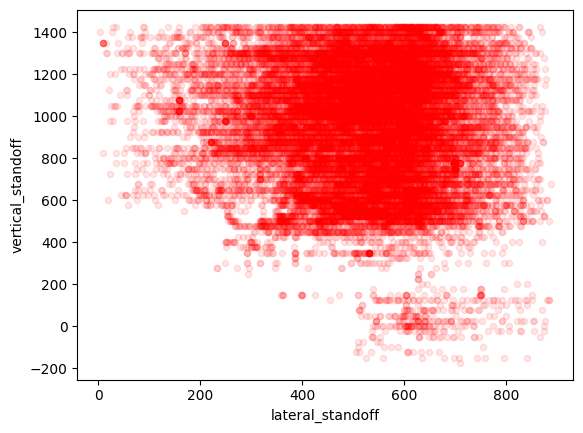

In [45]:
ax1 = gdf.plot(kind='scatter', x='lateral_standoff', y='vertical_standoff', color='r', alpha = 0.1)

In [31]:
gdf.describe()

,time,lat,lon,velocity,heading,baroaltitude,geoaltitude,lastposupdate,lastcontact,hour,dist,gnd_elev,min_hgt,lidar_min_alt,lateral_standoff,vertical_standoff
count,2.764200e+04,27642.000000,27642.000000,27642.000000,27642.000000,27642.000000,27642.000000,2.764200e+04,2.764200e+04,2.764200e+04,27642.000000,27642.000000,27642.000000,27642.000000,27642.000000,27642.000000
mean,1.644910e+09,50.941576,6.957933,42.448771,190.792163,447.840263,548.904641,1.644910e+09,1.644910e+09,1.644908e+09,7708.837233,51.920073,484.563692,496.142130,522.306348,-300.832892
std,1.802893e+07,0.003371,0.005540,12.962538,105.847429,155.567533,87.374860,1.802893e+07,1.802893e+07,1.802896e+07,5645.120040,9.326913,55.513921,28.799541,142.861529,87.374860
min,1.609574e+09,50.935867,6.948547,5.865564,0.000000,15.240000,205.740000,1.609574e+09,1.609574e+09,1.609571e+09,0.000000,37.151001,337.151001,417.450000,2.853138,-643.997533
25%,1.627753e+09,50.938390,6.952744,37.104218,108.824710,365.760000,487.680000,1.627753e+09,1.627753e+09,1.627751e+09,5011.618927,40.941998,458.339581,487.880000,434.297099,-362.057533
50%,1.650458e+09,50.941695,6.958280,44.670805,177.151742,449.580000,563.880000,1.650458e+09,1.650458e+09,1.650456e+09,6685.281554,54.858158,514.550079,512.360000,536.921622,-285.857533
75%,1.659110e+09,50.944628,6.963120,50.666858,296.565051,525.780000,617.220000,1.659110e+09,1.659110e+09,1.659107e+09,9381.409430,59.617916,514.550079,512.360000,619.247964,-232.517533
max,1.677597e+09,50.947048,6.966371,120.367804,359.510304,18257.520000,693.420000,1.677597e+09,1.677597e+09,1.677596e+09,87089.629223,67.169701,523.595840,515.910000,886.798409,-156.317533


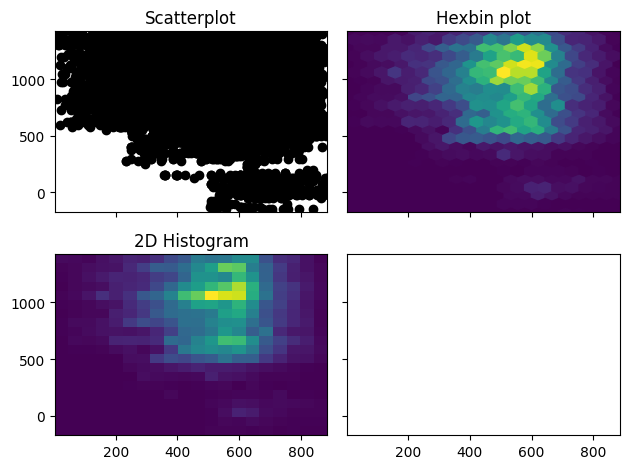

In [36]:
x = gdf.lateral_standoff
y = gdf.vertical_standoff

nbins = 20

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

axes[0, 0].set_title('Scatterplot')
axes[0, 0].plot(x, y, 'ko')

axes[0, 1].set_title('Hexbin plot')
axes[0, 1].hexbin(x, y, gridsize=nbins)

axes[1, 0].set_title('2D Histogram')
axes[1, 0].hist2d(x, y, bins=nbins)

fig.tight_layout()
plt.show()

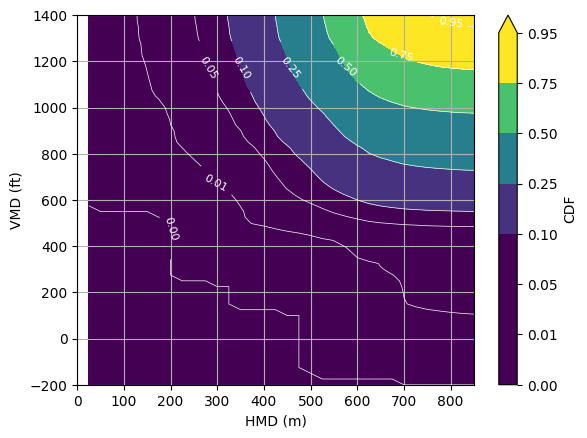

In [52]:
from matplotlib.colors import ListedColormap

# Assuming the DataFrame is named df with columns hmd_ft and vmd_ft
maxHmd_ft = gdf['lateral_standoff'].max()
maxVmd_ft = gdf['vertical_standoff'].max()

# Calculate bin centers
edgesX_ft = np.arange(0, maxHmd_ft + 25, 25)
edgesY_ft = np.arange(-maxVmd_ft, maxVmd_ft + 25, 25)
centersX_ft = edgesX_ft[:-1] + np.diff(edgesX_ft) / 2
centersY_ft = edgesY_ft[:-1] + np.diff(edgesY_ft) / 2

# 2D Histogram
hist, xedges, yedges = np.histogram2d(gdf['lateral_standoff'], gdf['vertical_standoff'], bins=(centersX_ft, centersY_ft), density=False)

# Normalize the histogram to create CDF
cdf = hist.cumsum(axis=0).cumsum(axis=1) / hist.sum()

# Calculate bin centers using output of np.histogram2d
Xcenters = xedges[:-1] + np.diff(xedges) / 2
Ycenters = yedges[:-1] + np.diff(yedges) / 2

# Plot CDF contour
fig, ax = plt.subplots()
c_levels = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.95]
c_map = ListedColormap(plt.get_cmap('viridis')(np.linspace(0, 1, len(c_levels))))
CS = ax.contourf(Xcenters, Ycenters, cdf.T, levels=c_levels, cmap=c_map, extend='max')
cbar = fig.colorbar(CS, ticks=c_levels, boundaries=np.linspace(0, 1, len(c_levels) + 1))
cbar.ax.set_ylabel('CDF')

# Add contour lines with labels
CS_lines = ax.contour(Xcenters, Ycenters, cdf.T, levels=c_levels, colors='white', linewidths=0.5)
ax.clabel(CS_lines, inline=True, fontsize=8, colors='white', fmt='%.2f')

# Axes labels and grid
ax.set_xlabel('HMD (m)')
ax.set_ylabel('VMD (ft)')
ax.grid(True)
ax.set_xlim(0, 850)
ax.set_ylim(-200, 1400)

plt.show()
